In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline


In [24]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
import torchvision.models as models
import glob
import os

In [12]:
path = "/home/robert/Neutrons_Net/HIDA-Neurones/data/HIDA-ufz_image_challenge/photos_annotated"


In [16]:
IMAGE_SUFFIX = "*jpg.jpg"
images = glob.glob(os.path.join(path, IMAGE_SUFFIX))

LABEL_SUFFIX = "*.jpg.png"
labels = glob.glob(os.path.join(path, LABEL_SUFFIX))

In [18]:
images[:3]

['/home/robert/Neutrons_Net/HIDA-Neurones/data/HIDA-ufz_image_challenge/photos_annotated/2019_0626_113722_189.jpg.jpg',
 '/home/robert/Neutrons_Net/HIDA-Neurones/data/HIDA-ufz_image_challenge/photos_annotated/2019_0626_093526_117.jpg.jpg',
 '/home/robert/Neutrons_Net/HIDA-Neurones/data/HIDA-ufz_image_challenge/photos_annotated/2019_0626_111222_115.jpg.jpg']

In [19]:
labels[:3]

['/home/robert/Neutrons_Net/HIDA-Neurones/data/HIDA-ufz_image_challenge/photos_annotated/2019_0626_081403_034.jpg.png',
 '/home/robert/Neutrons_Net/HIDA-Neurones/data/HIDA-ufz_image_challenge/photos_annotated/2019_0626_081645_042.jpg.png',
 '/home/robert/Neutrons_Net/HIDA-Neurones/data/HIDA-ufz_image_challenge/photos_annotated/2019_0626_095643_180.jpg.png']

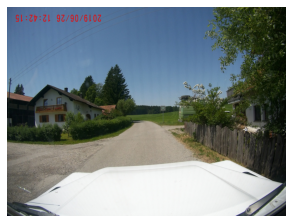

In [25]:
img_f = images[50]
img = open_image(img_f)
img.show(figsize=(5,5))

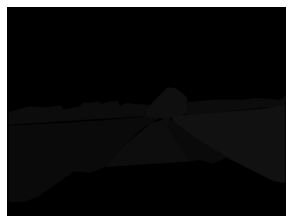

In [40]:
labl_f = labels[50]
img = open_image(labl_f)
img.show(figsize=(5,5))

In [14]:
dls = DataLoaders(tdl,tdl)
x = dls.train.one_batch()
x2 = first(tdl)
test_eq(x,x2)
x2 = dls.one_batch()
test_eq(x,x2)

array([720, 960])

In [15]:
mask.data

tensor([[[21, 21, 21,  ...,  4,  4,  4],
         [21, 21, 21,  ...,  4,  4,  4],
         [21, 21, 21,  ...,  4,  4,  4],
         ...,
         [17, 17, 17,  ..., 30, 30, 30],
         [17, 17, 17,  ..., 30, 30, 30],
         [17, 17, 17,  ..., 30, 30, 30]]])

In [16]:
size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=2
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=2, have 16119MB of GPU RAM free


In [17]:
codes = np.loadtxt(path/'codes.txt', dtype= str)

In [18]:
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [19]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes = codes))

In [20]:
data = (src
        .transform(get_transforms(), size= size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [21]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [22]:
learn = unet_learner(data, models.resnext50_32x4d, metrics = acc_camvid, wd= 1e-2)

In [23]:
free = gpu_mem_get_free_no_cache()
print (free)

13862


In [24]:
lr_find(learn)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


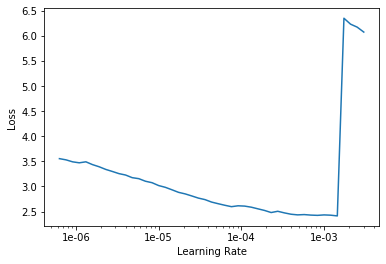

In [25]:
learn.recorder.plot()

In [26]:
lr=1e-04

In [27]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.855738,0.772821,0.803242,03:23
1,0.704410,0.589569,0.850829,03:19
2,0.607487,0.465767,0.874572,03:19
3,0.576090,0.578132,0.834569,03:18
4,0.510911,0.420309,0.883328,03:19
5,0.477878,0.407138,0.886436,03:18
6,0.483000,0.342825,0.911599,03:18
7,0.453496,0.361344,0.901018,03:17
8,0.410127,0.301749,0.912630,03:17
9,0.299711,0.242188,0.929328,03:17


In [28]:
learn.save('stage-1')

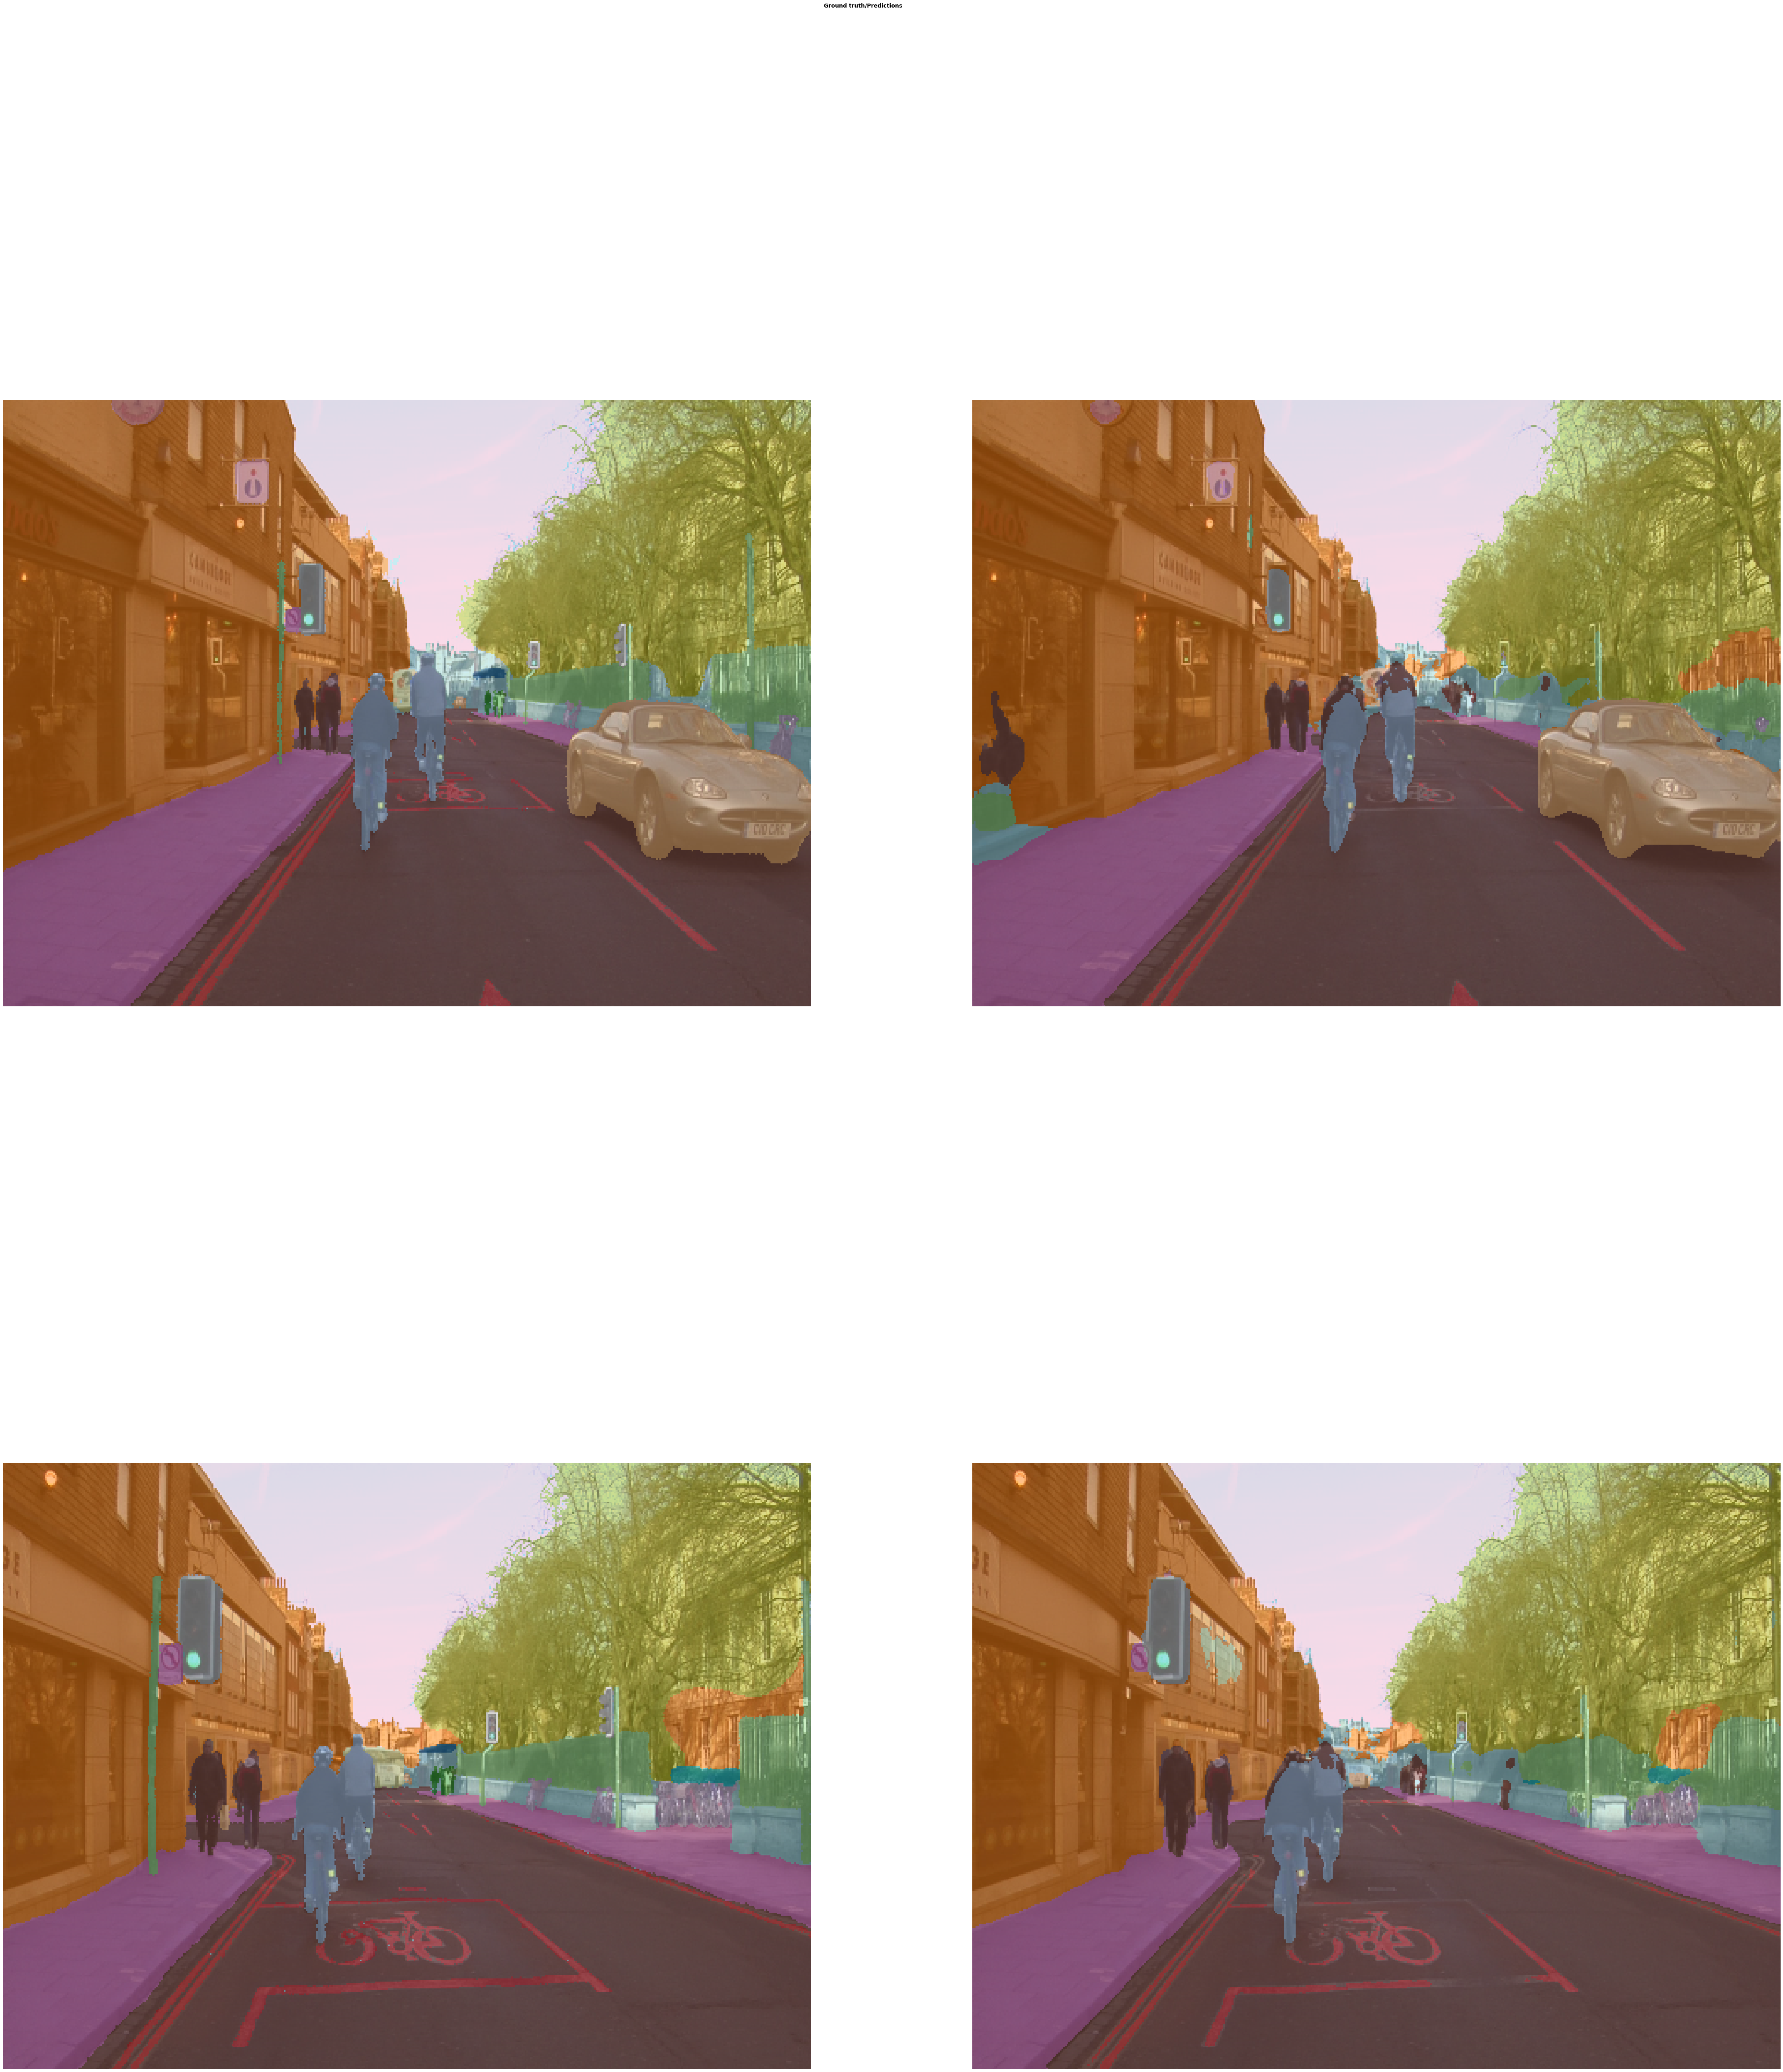

In [29]:
learn.show_results(rows=3, figsize=(80,90))

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [18]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
import torchvision.models as models



In [3]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/home/ubuntu/.fastai/data/camvid/images'),
 PosixPath('/home/ubuntu/.fastai/data/camvid/codes.txt'),
 PosixPath('/home/ubuntu/.fastai/data/camvid/labels'),
 PosixPath('/home/ubuntu/.fastai/data/camvid/valid.txt')]

In [4]:
path_img=path/'images'

In [5]:
path_lbl=path/'labels'

In [6]:
fnames = get_image_files (path_img)

In [7]:
lbl_names = get_image_files (path_lbl)

In [8]:
img_f = fnames[550]
img = open_image(img_f)


In [9]:
get_y_fn= lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

In [10]:
mask = open_mask(get_y_fn(img_f))


In [11]:
src_size = np.array(mask.shape[1:])

In [12]:
codes = np.loadtxt(path/'codes.txt', dtype= str)

In [13]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes = codes))

In [14]:
bs=2


In [15]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [16]:
data = (src
        .transform(get_transforms(), size= src_size//2, tfm_y=True) #changing the DataBunch to a original size of the image not to half!
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [19]:
learn = unet_learner(data, models.resnext50_32x4d, metrics = acc_camvid, wd= 1e-2)

In [20]:
learn.load('stage-1');

In [21]:
learn.unfreeze()

In [22]:
free = gpu_mem_get_free_no_cache()
print (free)

13822


In [23]:
lr_find(learn)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


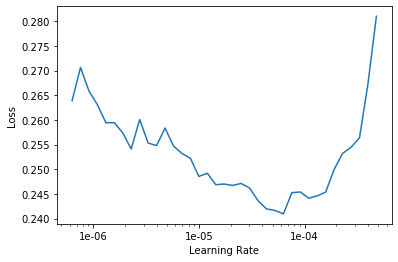

In [24]:
learn.recorder.plot()

In [25]:
lr=1e-04

In [26]:
lr2=slice(lr/400,lr/4)

In [27]:
learn.fit_one_cycle(10, lr2, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.285600,0.242074,0.928401,03:27
1,0.262703,0.239373,0.928551,03:24
2,0.258798,0.238074,0.929858,03:25
3,0.244133,0.247922,0.927949,03:25
4,0.248506,0.251084,0.926606,03:25
5,0.232518,0.241432,0.927386,03:25
6,0.224493,0.257480,0.922445,03:25
7,0.223283,0.259026,0.926353,03:25
8,0.217938,0.247988,0.927512,03:25
9,0.203344,0.239226,0.932035,03:25


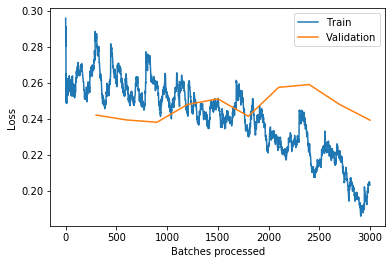

In [28]:
learn.recorder.plot_losses()

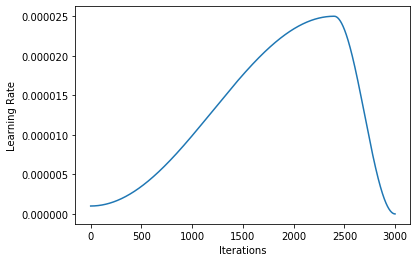

In [29]:
learn.recorder.plot_lr()

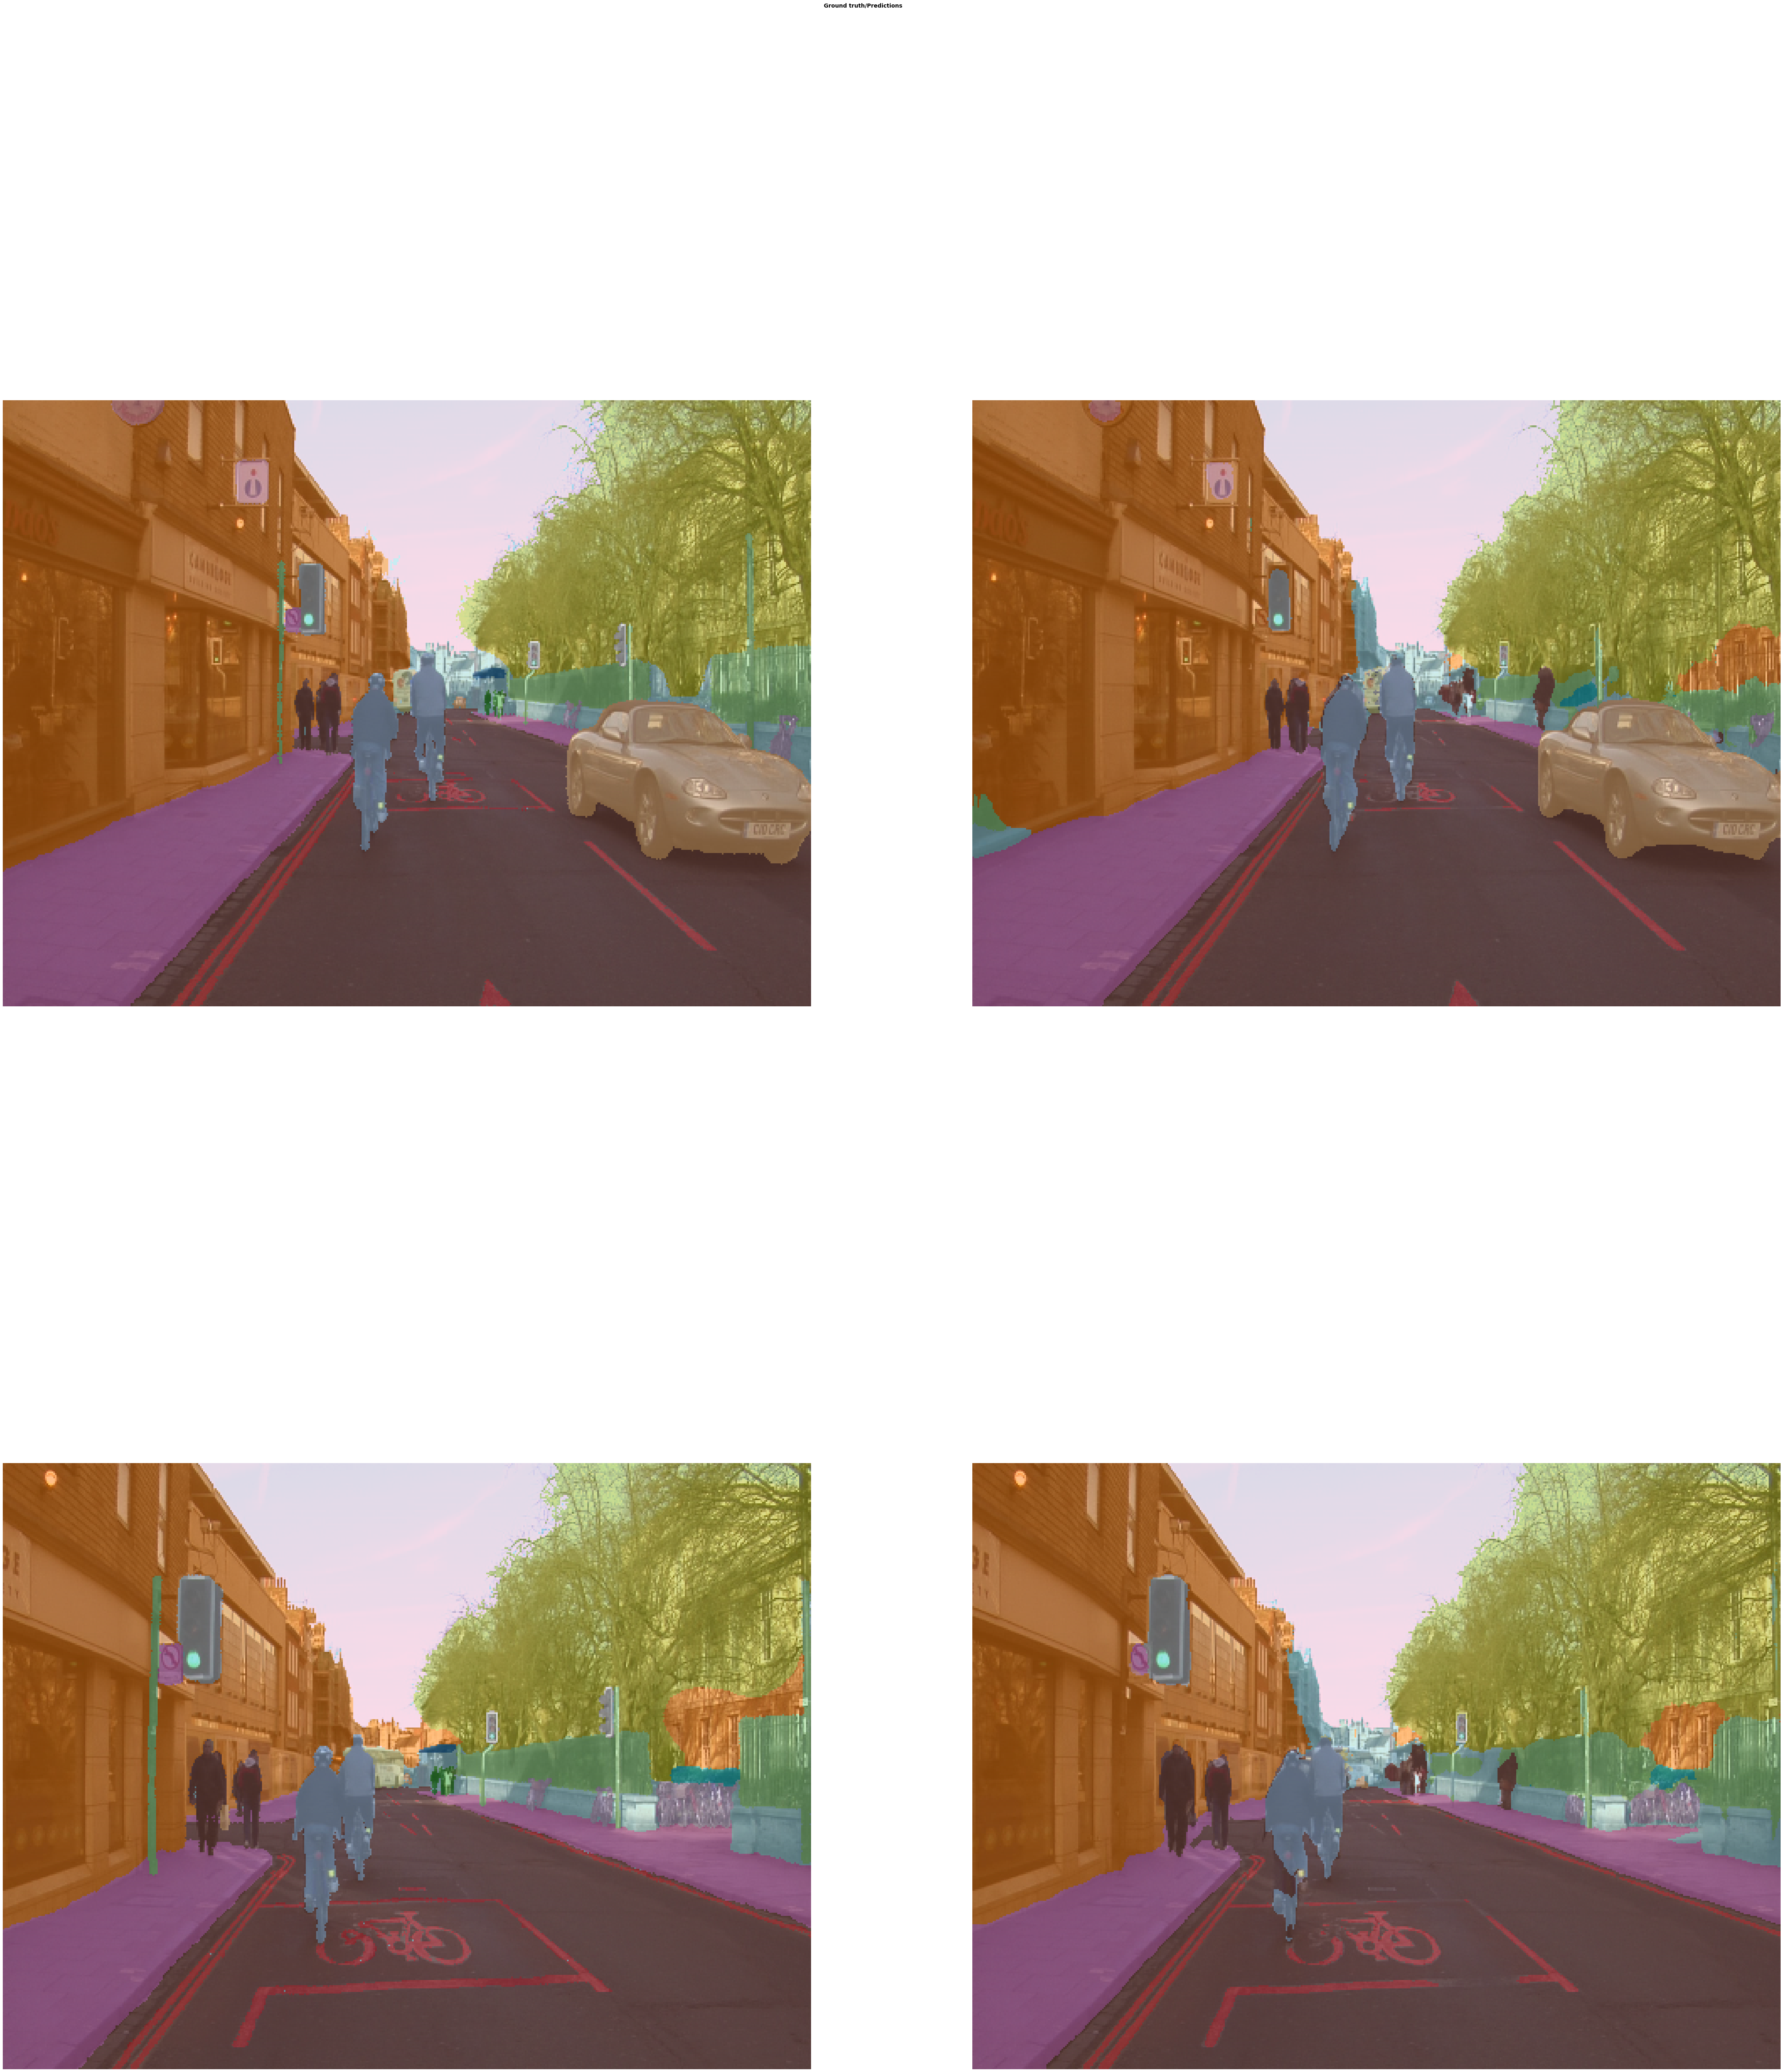

In [30]:
learn.show_results(rows=3, figsize=(80,90))

In [31]:
learn.save('stage-2')   #restart kernel for clearing of memory, after that reload all the weights!